$\newcommand{\myvector}[2]{\left\{ \begin{array}{c}#1\\#2\end{array} \right\}}$
$\newcommand{\mymatrix}[4]{\left[ \begin{array}{c}#1&#2\\#3&#4\end{array} \right]}$
$\newcommand{\sM}[1]{\boldsymbol{s}_{\mathrm{M#1}}}$
$\newcommand{\rvector}[1]{\boldsymbol{r}_{\mathrm{#1}}}$

# APPENDIX D:  Bayesian and least-squares results <span style="color:red">lack of</span> divergence


<br>
<br>

<div class="alert alert-info">

**Note:** This notebook was updated on 2021-05-18.  Previous versions of this notebook erroneously used a highly informative prior distribution for Bayesian IK calculations. This error has been corrected below in the [Systematic Approach Comparison](#systematic_approach_comparison) section. Corrected text has been <span style="color:red">highlighted in red</span>. For additional details please refer to Pohl et al. (2021) and also to the new Appendix F.
    
<br> 

Pohl AJ, MR Schofield, R Ferber (2021). Examination of a Bayesian approach to inverse kinematics. *J Biomech*, in press.

</div>

<br>
<br>


This Appendix <span style="color:red">originally described</span> a minimal inverse kinematics model for which Bayesian and least-sqaures results <span style="color:red">diverged. However, this divergence was caused by overly informative prior distributions. In interest of consistency with the previous Appendix D, this notebook makes minimal adjustments. Please refer to Pohl et al. (2021) and the new Appendix F for detailed explanations.</span>

<br>
<br>



### Model

The planar mechanism depicted below has two degrees of freedom (DOF): one translational and one rotational. The first (slider) segment moves to a position $y$ and the second segment rotates about point A to an angle $\theta$. Two markers (M1 and M2) are rigidly fixed to the rotating segment and have fixed local positions:  $\sM{1} = \myvector{35}{0}$ and $\sM{2} = \myvector{45}{0}$.

<br>
<br>

<center><img src="figs/rotating_slider.png" width="450"></center>

<br>
<br>

The three points' true global positions are:

\begin{align}
\rvector{A} &= \myvector{0}{y}\\ \\
\rvector{M1} &= \rvector{A} + \boldsymbol{R} \ \sM{1}\\ \\
\rvector{M2} &= \rvector{A} + \boldsymbol{R} \ \sM{2}
\end{align}

where $\boldsymbol{R}$ is the rotation matrix:

\begin{equation}
\boldsymbol{R} = \mymatrix{\cos\theta}{-\sin\theta}{\sin\theta}{\cos\theta}
\end{equation}

### Inverse kinematics (IK) problem

Imagine that we have measured the following marker positions:

\begin{align}
\rvector{M1}' &= \myvector{33.51}{12.11}\\ \\
\rvector{M2}' &= \myvector{42.63}{16.18}
\end{align}

The IK problem is to estimate $y$ and $\theta$ given these measurements.

For argument's sake let's say we also happen to know that the true values of the unknown variables are: $y$ = 0 and $\theta$ = 20 deg. In this case the true global marker positions are:

\begin{align}
\rvector{M1} &= \myvector{32.89}{11.97}\\ \\
\rvector{M2} &= \myvector{42.29}{15.39}
\end{align}

Let's assemble everything we know into Python for later use in our IK solutions.



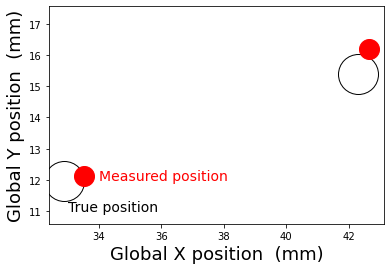

In [1]:
%matplotlib inline

from math import sin,cos,radians,degrees
import numpy as np
from matplotlib import pyplot

#(0) Define known values:
### local positions:
sM1        = np.array([35.0, 0.0])
sM2        = np.array([45.0, 0.0])
### measurements:
rpM1       = np.array([33.51, 12.11])
rpM2       = np.array([42.63, 16.18])
### true values: (not used in IK solutions, but useful for visualization)
y_true     = 0.0
theta_true = radians(20)



#(1) Compute global marker positions given y and theta:
def rotation_matrix(theta):
    '''Construct rotation matrix'''
    c,s    = cos(theta), sin(theta)
    R      = np.matrix(  [[c, -s], [s, c]] )
    return R

def rotate(R, r):
    '''Rotate a position vector r using rotation matrix R'''
    return np.asarray(  (R * np.mat(r).T)  ).flatten()

def get_positions(y, theta):
    '''Compute global marker positions given y and theta'''
    rA     = np.array([0, y])       #global A position
    R      = rotation_matrix(theta)
    rM1    = rA + rotate(R, sM1)    #global M1 position
    rM2    = rA + rotate(R, sM2)    #global M2 position
    return rM1,rM2

rM1,rM2    = get_positions(y_true, theta_true)



#(2) Plot:
pyplot.figure()
ax = pyplot.axes()
ax.plot(rM1[0],  rM1[1],  'o', markeredgecolor='k', markerfacecolor='w', ms=40)
ax.plot(rM2[0],  rM2[1],  'o', markeredgecolor='k', markerfacecolor='w', ms=40)
ax.plot(rpM1[0], rpM1[1], 'o', markeredgecolor='r', markerfacecolor='r', ms=20)
ax.plot(rpM2[0], rpM2[1], 'o', markeredgecolor='r', markerfacecolor='r', ms=20)
ax.text(33, 11, 'True position',     color='k', size=14)
ax.text(34, 12, 'Measured position', color='r', size=14)
ax.set_xlabel('Global X position  (mm)', size=18)
ax.set_ylabel('Global Y position  (mm)', size=18)
pyplot.axis('equal')
pyplot.show()

# Least-squares solution

This IK problem is relatively simple, so it could be solved using an analytical approach similar to the one presented in Appendix B. However, we'll be a bit lazy and instead solve the IK problem numerically, using the "get_positions" function that we've already written above.

Once we set values for $y$ and $\theta$ we know the global positions of $\rvector{M1}$ and $\rvector{M2}$, so we can compute the difference between those positions and our measurements as:

\begin{align}
\boldsymbol{\epsilon}_1 &= \rvector{M1}' - \rvector{M1}\\
\boldsymbol{\epsilon}_2 &= \rvector{M2}' - \rvector{M2}
\end{align}

We can then express total measurement error as follows:


\begin{equation}
f(y, \theta) =
\big| \ \boldsymbol{\epsilon}_1 \ \big| \ ^2 \
+ \
\big| \ \boldsymbol{\epsilon}_2 \ \big| \ ^2
\end{equation}

Although we have called $f(y, \theta)$ a "measurement error" function, the opposite perspective is equally apt: "guess error".  That is, if we know our measurement values ($\rvector{M1}'$, $\rvector{M2}'$) and then use $y$ and $\theta$ to guess the true marker positions ($\rvector{M1}$, $\rvector{M2}$), then $f(y, \theta)$ represents our guess error. We nevertheless use "measurement error" below because we presume there is no guess which can yield zero error. 

For later purposes let's bundle our two unknown variables into a generalized "unknowns" vector $\boldsymbol{x}$ as follows:


\begin{align}
\boldsymbol{x} = \myvector{y}{\theta}
\end{align}

Now our error function is:

\begin{align}
f(\boldsymbol{x}) =
\big| \ \boldsymbol{\epsilon}_1 \ \big| \ ^2 \
+ \
\big| \ \boldsymbol{\epsilon}_2 \ \big| \ ^2
\end{align}

Let's implement this function in Python and then explore its output to make sure it's returning reasonable values.


In [2]:
def measurement_error(x):
    y,theta = x 
    rM1,rM2 = get_positions(y, theta)
    e1,e2   = rpM1 - rM1, rpM2 - rM2
    e1,e2   = np.linalg.norm(e1), np.linalg.norm(e2)
    f       = e1**2 + e2**2
    return f

x = [0, radians(20)]
print( measurement_error(x) )

1.145633045191809


Here the total measurement error is 1.146 mm$^2$. By moving to a different vertical position (e.g. $y$=2) or a different angular position ($\theta$=10 deg) we see that measurement error increases:

In [3]:
print(   measurement_error( [2, radians(20)] )   )
print(   measurement_error( [0, radians(10)] )   )

5.4320789094058
110.13801125048406


Since we can compute the error function $f(y,\theta)$ for arbitrary $y$ and $\theta$ values we can view it as a three-dimensional surface as follows:

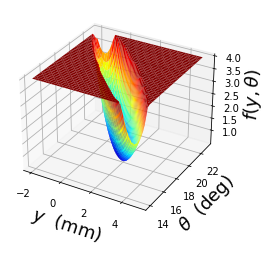

In [4]:
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D


### Compute error for a range of y and theta values:
Y       = np.linspace(-2, 5, 41)
THETA   = np.radians( np.linspace(14, 23, 41) )
Y,THETA = np.meshgrid(Y, THETA)
F       = [measurement_error(x)   for x in zip(Y.flatten(), THETA.flatten())]
F       = np.reshape(F, Y.shape)
F[F>4]  = 4  #cap all values at 4 to more clearly see the function's minimum


### Plot:
fig     = pyplot.figure()
ax      = fig.gca(projection='3d')
ax.plot_surface(Y, np.degrees(THETA), F, cmap=cm.jet, rstride=1, cstride=1, linewidth=0.2)
ax.set_xlabel(r'$y$  (mm)', size=18)
ax.set_ylabel(r'$\theta$  (deg)', size=18)
ax.set_zlabel(r'$f(y, \theta)$', size=18)
pyplot.show()

In the figure above it appears that our error function's minimum value occurs for approximately $y$=1.5 and $\theta$=19, but let's find its minimum value algorithmically using **scipy.optimize.minimize** as follows:

In [5]:
from scipy import optimize

x0       = [0, radians(20)]  #initial (y, theta) guess
results  = optimize.minimize(measurement_error, x0)

print('Least-squares estimates:')
print('   y     = %.3f' %results.x[0])
print('   theta = %.3f' %degrees(results.x[1]) )

Least-squares estimates:
   y     = 1.321
   theta = 18.700


Due to measurement error our final estimates for $y$ and $\theta$ are slightly different from their true values ($y$=0, $\theta$=20).

# Bayesian approach

The figure below depicts a stochastic forward-kinematics model for this system.  Once the numerical values of $y$ and $\theta$ are known we know the values of our deterministic variables $\rvector{M1}$ and $\rvector{M2}$.  Similarly, once the numerical value of our measurement error $\epsilon$ is known we will also know the value of our generalized measurement vector $\boldsymbol{q}$, where $\boldsymbol{q}$ contains all four measured coordinates from $\rvector{M1}'$ and $\rvector{M2}'$. Let's implement this model in PyMC.

<img src="figs/bikmodel2.png" width="300">

In [6]:
import pymc


q_observed = np.asarray([rpM1, rpM2]).flatten() #measured positions
tau        = 20  #presumed measurement precision (we'll relax this later)
y          = pymc.Normal("y", 0, 1)  #prior for y
theta      = pymc.Uniform("theta", radians(-45), radians(45))  #prior for theta


@pymc.deterministic
def observations_model(y=y, theta=theta):
    rM1,rM2 = get_positions(y, theta)
    q       = np.asarray([rM1, rM2]).flatten()
    return q
q_model   = pymc.Normal("q", observations_model, tau, value=q_observed, observed=True)

Now that we have a model of our observations we can set values for $y$ and $\theta$ and then check what kinds of results our model produces.

In [7]:
y.set_value(0)
theta.set_value( radians(20) )
print( q_model.random() )
print( q_model.random() )
print( q_model.random() )

[32.99941182 12.00754189 42.07943539 15.2370373 ]
[32.90132008 11.85785493 41.9218965  15.34236793]
[32.65119733 12.20083499 42.50388501 15.61976264]


The first two columns represent $\rvector{M1}'$ and the last two columns represent $\rvector{M2}'$.  We can see that these values are similar to our actual measured values, so our model appears to have been specified correctly. 

Variability exists in these values because we have not set the value of our last stochastic variable ($\epsilon$); this variability is built into the model above via the parameter "tau" which specifies our measurement precision.  If we raise tau to a very high value we will see that the model's results become much less variable.

In [8]:
tau       = 1e9
q_model   = pymc.Normal("q", observations_model, tau, value=q_observed, observed=True)
print( q_model.random() )
print( q_model.random() )
print( q_model.random() )
print( q_model.random() )
print( q_model.random() )

[32.88922646 11.97069963 42.28610841 15.39090322]
[32.88926753 11.97069683 42.28612075 15.39091761]
[32.88925811 11.97069876 42.28614937 15.39092467]
[32.88921084 11.97069041 42.28619638 15.39091307]
[32.88927265 11.97069497 42.28614831 15.39087162]


Now let's relax our assumptions regarding tau's true value, then use PyMC to run Markov-Chain Monte-Carlo simulations with the goal of finding posterior distributions for $y$ and $\theta$ (and tau) which are most consistent with the observed marker positions.

In [9]:
tau        = pymc.Normal("tau", 20, 1)  #prior for measurement precision
y          = pymc.Normal("y", 0, 1)     #prior for y
theta      = pymc.Uniform("theta", radians(-45), radians(45))  #prior for theta

@pymc.deterministic
def observations_model(y=y, theta=theta):
    rM1,rM2 = get_positions(y, theta)
    q       = np.asarray([rM1, rM2]).flatten()
    return q
q_model   = pymc.Normal("q", observations_model, tau, value=q_observed, observed=True)


mcmc      = pymc.MCMC([q_model, y, theta, tau])
mcmc.sample(40000, 20000)
Y         = mcmc.trace('y')[:]
THETA     = np.degrees( mcmc.trace('theta')[:] )
TAU       = np.degrees( mcmc.trace('tau')[:] )

print('\n\nBayesian estimates:')
print('   y     = %.3f' %Y.mean() )
print('   theta = %.3f' %THETA.mean() )

 [-----------------100%-----------------] 40000 of 40000 complete in 7.7 sec

Bayesian estimates:
   y     = 1.073
   theta = 19.029


Our Bayesian estimates for $y$ and $\theta$ are somewhat closer to their true values than are our least-squares estimates. But this is just for one case.  Let's now compare the two approaches' results more systematically.

<a name="systematic_approach_comparison"></a>
# Systematic approach comparison


First let's pick some new true values for $y$ and $\theta$ and then generate ten random datasets based on those true values.

In [10]:
y_true      = -0.1
theta_true  = radians(5)
rM1,rM2     = get_positions(y_true, theta_true) 
q_true      = np.array([rM1, rM2]).flatten()

nIterations = 10
noise_amp   = 0.5
np.random.seed(0)
Q_obs       = q_true + noise_amp * np.random.randn(nIterations, 4)

print(Q_obs)

[[35.74884061  3.1505296  45.31813041  4.94245502]
 [35.80059343  2.46181206 45.30380562  3.74632982]
 [34.81520501  3.15575025 44.9007832   4.54914518]
 [35.2473333   3.0112885  45.05069303  3.98884559]
 [35.61385397  2.84787186 44.98529526  3.39496055]
 [33.59031953  3.27726029 45.26097951  3.45092591]
 [36.00169175  2.22326816 44.85164067  3.7284165 ]
 [35.63320404  3.68513038 44.90623513  4.01108968]
 [34.42292156  1.96005276 44.65480534  3.90018291]
 [35.48195977  3.55164092 44.63509801  3.67085705]]


These are the ten measurements we'll test. Let's first compute the least-squares solutions for each set of measurements.

In [11]:
def measurement_error(x, q_obs):
    y,theta = x
    rpM1    = q_obs[:2]
    rpM2    = q_obs[2:]
    rM1,rM2 = get_positions(y, theta)
    e1,e2   = rpM1 - rM1, rpM2 - rM2
    e1,e2   = np.linalg.norm(e1), np.linalg.norm(e2)
    f       = e1**2 + e2**2
    return f

def solution_ls(q_obs):
    x0      = [y_true, theta_true]  #initial (y, theta) guess
    results = optimize.minimize(measurement_error, x0, args=(q_obs,))
    y,theta = results.x
    return y, degrees(theta)

np.set_printoptions(precision=3, suppress=True)
RESULTS_LS  = np.array([solution_ls(q_obs)  for q_obs in Q_obs])
print('Least-squares results:')
print('   y     = %s' %RESULTS_LS[:,0])
print('   theta = %s' %RESULTS_LS[:,1])

Least-squares results:
   y     = [ 0.568  0.501 -0.742  0.672  1.625  1.289 -0.372  2.901 -3.663  3.141]
   theta = [4.988 3.732 6.596 4.055 2.144 2.974 4.801 1.356 9.488 0.674]


<br> 
<br> 

Next let's get Bayesian estimates for each dataset.


<br> 
<br> 

<div class="alert alert-info">

**2021-05-14 update:** &nbsp; Code in subsequent cells has been updated. While a variety of minor changes have been made, only one major change has been:  use of less-informative priors  in `solution_bayesian`;  this function now uses only the LS solution and not the true solution to inform the priors. For a more systematic comparison of priors see Appendix F.
    
</div>

<br> 
<br> 


In [12]:
def solution_bayesian(q_obs):
    qls     = solution_ls( q_obs )  # LS solution (y,theta)
    yls     = qls[0]                # LS solution (y)
    thetals = radians( qls[1] )     # LS solution (theta)
    tau     = pymc.Normal("tau", 1/(noise_amp**2), 1)    # a highly informative prior for noise magnitude
    y       = pymc.Normal("y", yls, 1, value=yls)        # a moderately informative prior for y
    theta   = pymc.Uniform("theta", thetals-radians(45), thetals+radians(45), value=thetals)  # a moderately informative prior for y

    @pymc.deterministic
    def observations_model(y=y, theta=theta):
        rM1,rM2 = get_positions(y, theta)
        q       = np.asarray([rM1, rM2]).flatten()
        return q
    q_model   = pymc.Normal("q", observations_model, tau, value=q_obs, observed=True)

    mcmc      = pymc.MCMC([q_model, y, theta, tau])
    mcmc.sample(40000, 20000, progress_bar=False)
    Y         = mcmc.trace('y')[:]
    THETA     = np.degrees( mcmc.trace('theta')[:] )
    
    return Y.mean(), THETA.mean()

RESULTS_B = np.zeros((nIterations,2))
for i,q_obs in enumerate(Q_obs):
    print('Iteration %d of %d...' %(i+1, nIterations))
    y,theta = solution_bayesian(q_obs)
    RESULTS_B[i] = [y, theta]
    print('   y = %.3f,  theta = %.3f' %(y,theta))


Iteration 1 of 10...
   y = 0.572,  theta = 4.991
Iteration 2 of 10...
   y = 0.515,  theta = 3.716
Iteration 3 of 10...
   y = -0.816,  theta = 6.715
Iteration 4 of 10...
   y = 0.591,  theta = 4.171
Iteration 5 of 10...
   y = 1.732,  theta = 1.978
Iteration 6 of 10...
   y = 1.198,  theta = 3.120
Iteration 7 of 10...
   y = -0.354,  theta = 4.773
Iteration 8 of 10...
   y = 2.892,  theta = 1.368
Iteration 9 of 10...
   y = -3.630,  theta = 9.439
Iteration 10 of 10...
   y = 3.171,  theta = 0.640


Here is a summary of IK error for the two approaches:

In [13]:
x_true   = [y_true, degrees(theta_true)]
error_LS = RESULTS_LS - x_true
error_B  = RESULTS_B - x_true

print('Average absolute error (least-squares):')
print('   y: %.3f,  theta: %.3f' %tuple( np.abs(error_LS).mean(axis=0) ) )
print('Average absolute error (Bayesian):')
print('   y: %.3f,  theta: %.3f' %tuple( np.abs(error_B).mean(axis=0) ) )


Average absolute error (least-squares):
   y: 1.587,  theta: 2.136
Average absolute error (Bayesian):
   y: 1.587,  theta: 2.140


<br>

<span style="color:red">On average there is little-to no improvement over the LS solutions.</span>


Finally, let's check how the least-squares and Bayesian approaches compare on a case-by-case basis.

<br>

In [14]:
error_difference = np.abs(error_LS) - np.abs(error_B)
print(error_difference)

[[-0.004  0.002]
 [-0.014 -0.016]
 [-0.073 -0.119]
 [ 0.081  0.116]
 [-0.107 -0.166]
 [ 0.091  0.147]
 [ 0.018 -0.027]
 [ 0.01   0.012]
 [ 0.033  0.049]
 [-0.03  -0.034]]


Positive values indicate that the least-squares solution had greater error and negative values indicate the opposite.

<span style="color:red">This again shows that the Bayesian approach yields little improvement.</span>

# Summary

This Appendix shows that Bayesian and least-squares (LS) inverse kinematics (IK) estimates <span style="color:red">are not expected to diverge</span> for simple planar rotations. <span style="color:red">Refer to Appendix F for a consideration of how informative priors lead to different results like those reported in the original Appendix D.</span>